# Title: AIDI 1002 Final Term Project Report

#### Divyakumar Patel(200574156)
#### Dhruvkumar Prajapati(200576299)

####  Emails:
####  200574156@student.georgianc.on.ca
####  200576299@student.georgianc.on.ca

# Introduction:

#### Problem Description:

The implementation and assessment of the DETR (DEtection Transformer) model for object detection is the main goal of our project. Based on the research document "End-to-End Object Detection with Transformers" by Nicolas Carion et al. (2020), the DETRdemo implementation forms the basis.

#### Context of the Problem:

A fundamental task in computer vision, object detection has applications in anything from driverless vehicles to spying. Investigating and improving the DETR model for effective and precise object detection is our aim.

#### Limitation About other Approaches:

Traditional approaches, such attention-based sequence-to-sequence models or MLPs, frequently have issues with accuracy and flexibility when dealing with uncertain responses.

#### Solution:

Our implementation utilizes DETRdemo, a minimalistic version of the DETR model. We aim to explore and improve specific aspects of the model, such as to elevate its performance.

# Background

Explain the related work using the following table

| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Carion et al. [1] | End-to-End Object Detection with Transformers| COCO | Limited discussion on scalability and real-time performance


The last row in this table should be about the method discussed in this paper (If you can't find the weakenss of this method then write about the future improvement, see the future work section of the paper)

# Methodology

Existing Method
A conversion layer, and a ResNet-50 backbone make up the DETRdemo model. An FC bbox predictor and learnt positional encoding are used. On COCO val5k, the model achieves about 40 AP. 

Contribution

Proposed Changes
We have made the following primary contributions: To increase the performance of the model, we intend to test and refine features such as specify particular parameters or components you aim to tweak or improve.

# Implementation

In this section, you will provide the code and its explanation. You may have to create more cells after this. (To keep the Notebook clean, do not display debugging output or thousands of print statements from hundreds of epochs. Make sure it is readable for others by reviewing it yourself carefully.)

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [2]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [3]:
# Instantiate the model and load pre-trained weights
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.RandomResizedCrop(800),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

C:\Users\DELL\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
# Function to rescale bounding boxes
def rescale_bboxes(boxes, original_size):
    h, w = original_size
    scaled_boxes = boxes.clone()
    scaled_boxes[:, 0] *= w  # xmin
    scaled_boxes[:, 1] *= h  # ymin
    scaled_boxes[:, 2] *= w  # xmax
    scaled_boxes[:, 3] *= h  # ymax
    return scaled_boxes

# Function to perform object detection
def detect(im, model, transform):
    # Mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # Demo model only supports by default images with an aspect ratio between 0.5 and 2
    # If you want to use images with an aspect ratio outside this range,
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 pixels on each side'

    # Propagate through the model
    outputs = model(img)

    # Keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # Convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

# Function to plot results
def plot_results(pil_img, prob, boxes):
    results_text = []
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        results_text.append(text)
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

    return results_text

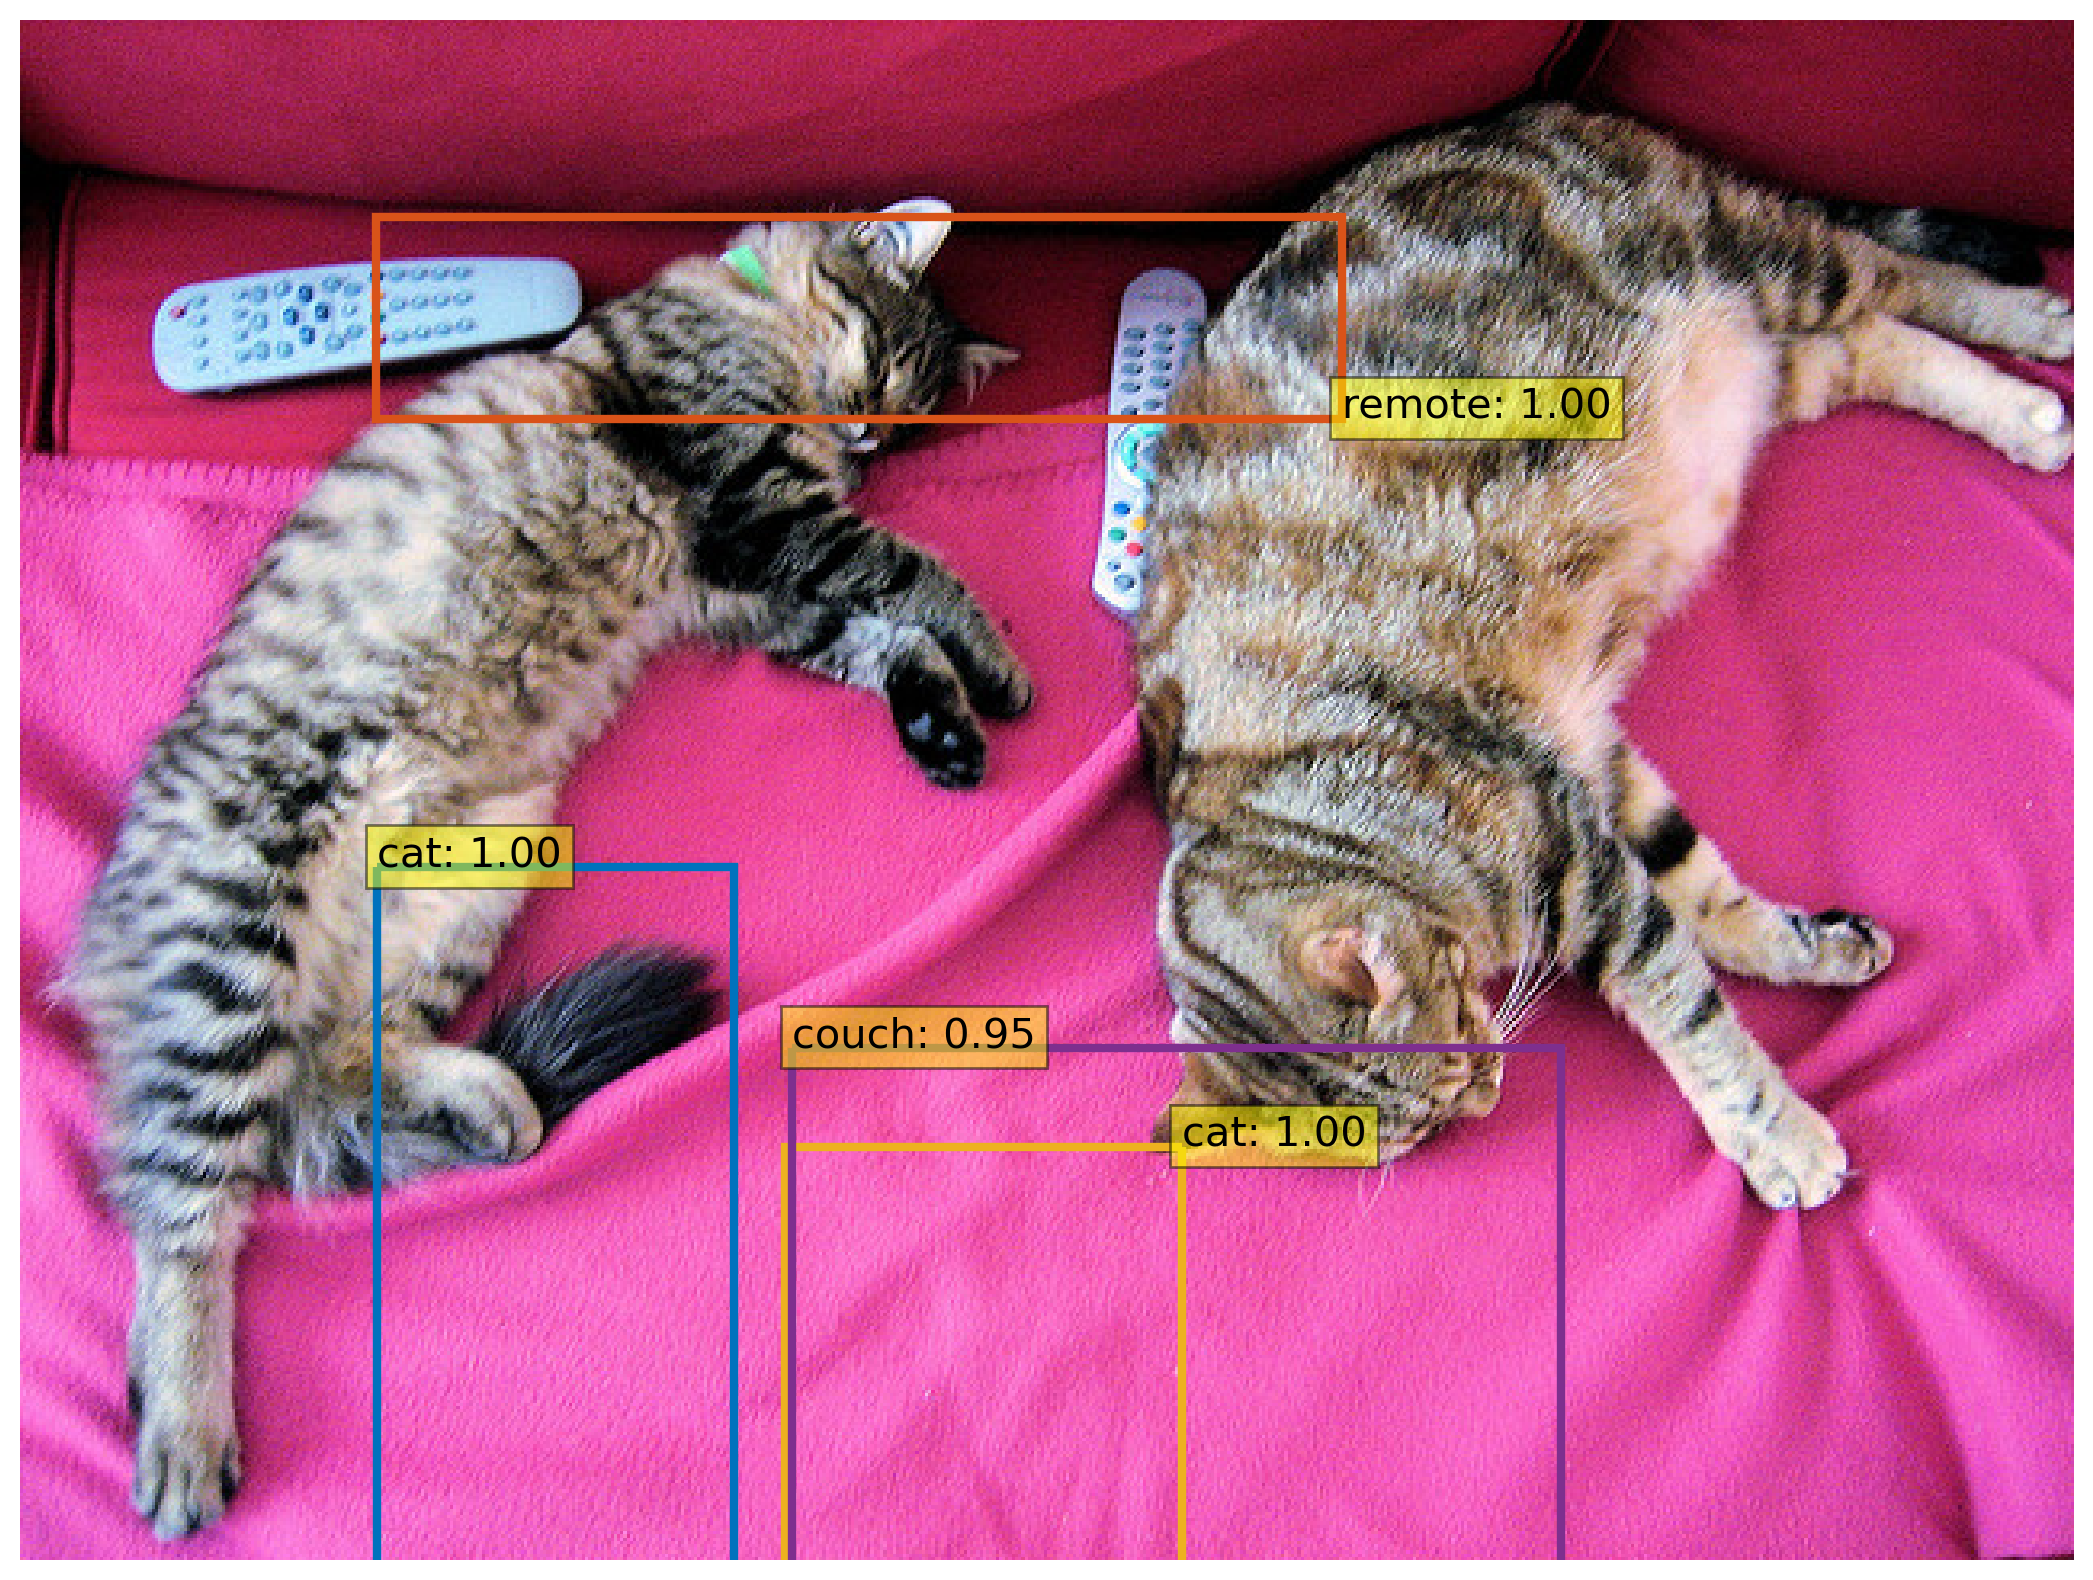

cat: 1.00
remote: 1.00
cat: 1.00
couch: 0.95


In [2]:
# Function to print text results
def print_text_results(text_results):
    for text_result in text_results:
        print(text_result)

# URL of the input image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

# Perform object detection
scores, boxes = detect(im, detr, transform)

# Plot results and print text results
text_results = plot_results(im, scores, boxes)
print_text_results(text_results)


# Conclusion and Future Direction

### Learnings from the Project

We learned a great deal about the use of transformer-based models in object detection during the project. The DETR model is a viable contender for a number of computer vision applications due to its simplicity and efficacy. Among our main conclusions are:
Effective Detection: The DETR model greatly simplifies the object detection pipeline by doing away with the requirement for manually-designed elements like anchor creation and non-maximum suppression techniques.

versatility:DETR's adaptability in handling various computer vision problems is demonstrated by its ability to create panoptic segmentation in a unified manner.

### Future Directions

We intend to investigate prospective areas for development or expansion in the future. This might entail:

Real-time Performance OptimiZation: Resolving the scalability issues and carrying out tests to improve the real-time performance of DETR, particularly in scenarios with limited resources.

Adaptation to specific Domains: Examining how well DETR performs in specialised applications by seeing how well it adapts to datasets and scenarios unique to a certain domain.

Integration with Augmentation Techniques: Investigating how to include sophisticated data augmentation methods to enhance the resilience and generalisation of the model.

We hope to further the knowledge and advancement of transformer-based models in computer vision by tackling these aspects.

# References:

[1]:  Nicolas Carion et al., "End-to-End Object Detection with Transformers," arXiv:2005.12872 [cs.CV], 2020. https://link.springer.com/chapter/10.1007/978-3-030-58452-8_13